In [ ]:
  pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

# Load the dataset
data = pd.read_csv('aqi_data.csv')

# Define features and target
X = data[['pm25','pm10', 'o3', 'no2', 'so2', 'co']]
y = data['aqi']

# Define AQI categories (bins and labels)
bins = [0, 50, 100, 150, 200, 300, 500]  # Example thresholds for AQI
labels = [0, 1, 2, 3, 4, 5]  # Categories: 0 = Good, ..., 5 = Hazardous

# Add AQI category to the dataset (for reference)
data['aqi_category'] = pd.cut(data['aqi'], bins=bins, labels=labels, right=False)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Instantiate the CatBoost model with adjusted hyperparameters
model = CatBoostRegressor(iterations=300,
                          depth=5,
                          learning_rate=0.05,
                          loss_function='RMSE',
                          random_state=42,
                          verbose=200)

# Train the model on the training set
model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Calculate metrics on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Metrics:")
print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"  Mean Absolute Error (MAE): {mae:.2f}")
print(f"  R-squared (R²): {r2:.2f}")

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse_list = []
cv_mae_list = []
cv_r2_list = []

for train_index, test_index in kf.split(X_scaled):
    X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model_cv = CatBoostRegressor(iterations=300,
                                 depth=5,
                                 learning_rate=0.05,
                                 loss_function='RMSE',
                                 random_state=42,
                                 verbose=200)
    model_cv.fit(X_train_cv, y_train_cv)

    # Predict and calculate metrics
    y_pred_cv = model_cv.predict(X_test_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_test_cv, y_pred_cv))
    mae_cv = mean_absolute_error(y_test_cv, y_pred_cv)
    r2_cv = r2_score(y_test_cv, y_pred_cv)

    cv_rmse_list.append(rmse_cv)
    cv_mae_list.append(mae_cv)
    cv_r2_list.append(r2_cv)

# Calculate average cross-validation metrics
cv_rmse = np.mean(cv_rmse_list)
cv_mae = np.mean(cv_mae_list)
cv_r2 = np.mean(cv_r2_list)

print(f"\nCross-Validated Metrics (5-Fold):")
print(f"  Root Mean Squared Error (CV-RMSE): {cv_rmse:.2f}")
print(f"  Mean Absolute Error (CV-MAE): {cv_mae:.2f}")
print(f"  R-squared (CV-R²): {cv_r2:.2f}")

# User input function to predict AQI and AQI category
def predict_aqi_and_category():
    print("\nEnter the values for the following parameters:")

    # Take user input for AQI factors
    try:
        pm25 = float(input("PM2.5 (µg/m³): "))
        pm10 = float(input("PM10 (µg/m³): "))
        no2 = float(input("NO2 (µg/m³): "))
        co = float(input("CO (mg/m³): "))
        so2 = float(input("SO2 (µg/m³): "))
        o3 = float(input("Ozone (µg/m³): "))

        # Create a DataFrame with user inputs
        input_data = pd.DataFrame([[pm25, pm10, o3, no2, so2, co]],
                                  columns=['pm25','pm10', 'o3', 'no2', 'so2', 'co'])

        # Standardize the input data
        input_scaled = scaler.transform(input_data)

        # Predict AQI using the trained model
        predicted_aqi = model.predict(input_scaled)[0]

        # Determine the AQI category based on bins
        predicted_category = pd.cut([predicted_aqi], bins=bins, labels=labels, right=False)[0]

        # Map category to the label description
        category_descriptions = {
            0: "Good",
            1: "Moderate",
            2: "Unhealthy for Sensitive Groups",
            3: "Unhealthy",
            4: "Very Unhealthy",
            5: "Hazardous"
        }

        print(f"\nPredicted AQI: {predicted_aqi:.2f}")
        print(f"Predicted AQI Category: {predicted_category} ({category_descriptions.get(predicted_category, 'Unknown')})")
    except ValueError:
        print("Invalid input. Please enter numeric values only.")

# Call the function to take user input and predict AQI and category
predict_aqi_and_category()


0:	learn: 81.7111335	total: 81.4ms	remaining: 24.3s
200:	learn: 6.3762526	total: 3.14s	remaining: 1.54s
299:	learn: 5.2674916	total: 5.49s	remaining: 0us
Test Set Metrics:
  Root Mean Squared Error (RMSE): 5.89
  Mean Absolute Error (MAE): 2.54
  R-squared (R²): 1.00
0:	learn: 81.7111335	total: 27.8ms	remaining: 8.33s
200:	learn: 6.3497099	total: 3.86s	remaining: 1.9s
299:	learn: 5.2727029	total: 5.51s	remaining: 0us
0:	learn: 82.7528513	total: 45.2ms	remaining: 13.5s
200:	learn: 6.2573963	total: 2.56s	remaining: 1.26s
299:	learn: 5.1441353	total: 4.15s	remaining: 0us
0:	learn: 82.5917847	total: 31.2ms	remaining: 9.33s
200:	learn: 6.0699879	total: 3.1s	remaining: 1.53s
299:	learn: 4.7473863	total: 4.41s	remaining: 0us
0:	learn: 82.9823317	total: 5.8ms	remaining: 1.73s
200:	learn: 6.0387973	total: 1.13s	remaining: 556ms
299:	learn: 4.9372167	total: 1.7s	remaining: 0us
0:	learn: 81.6871408	total: 7.52ms	remaining: 2.25s
200:	learn: 5.9945498	total: 1.11s	remaining: 545ms
299:	learn: 4.67

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

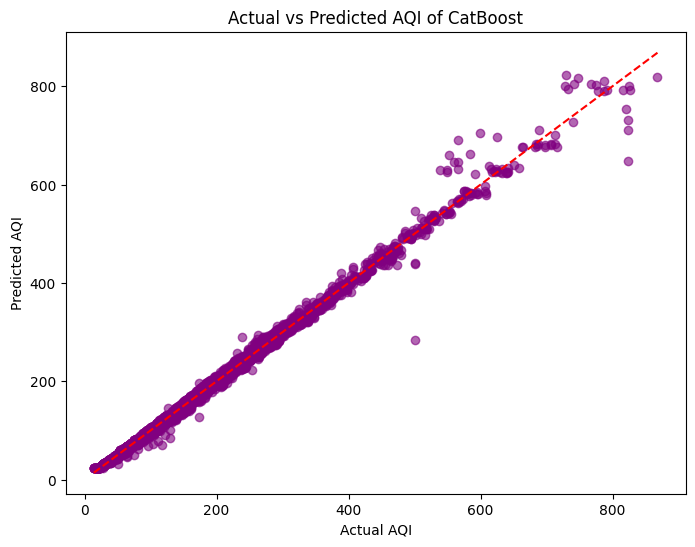

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.title("Actual vs Predicted AQI of CatBoost")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.show()

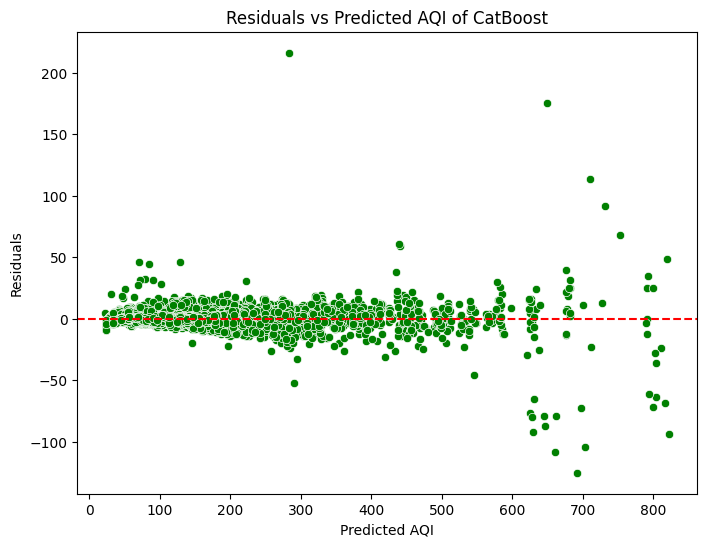

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted AQI of CatBoost")
plt.xlabel("Predicted AQI")
plt.ylabel("Residuals")
plt.show()


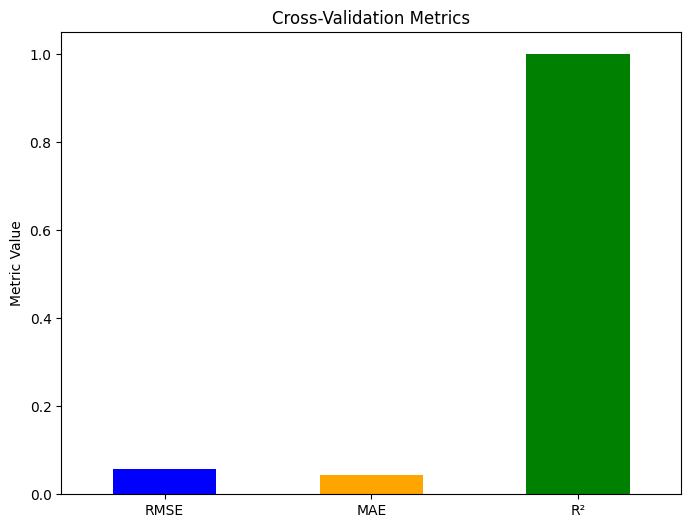

In [ ]:
cv_metrics = {'RMSE': cv_rmse_list, 'MAE': cv_mae_list, 'R²': cv_r2_list}
cv_df = pd.DataFrame(cv_metrics)

cv_df.mean().plot(kind='bar', figsize=(8, 6), color=['blue', 'orange', 'green'])
plt.title("Cross-Validation Metrics")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

# Load the dataset
data = pd.read_csv('aqi_data.csv')

# Define features and target
X = data[['pm25', 'pm10', 'no2', 'co', 'so2', 'ozone']]
y = data['aqi']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the model
cat_model = CatBoostRegressor(random_state=42, loss_function='RMSE', verbose=0)

# Define the grid of hyperparameters
param_grid = {
    'iterations': [300, 500],
    'depth': [4, 5, 6],
    'learning_rate': [0.01, 0.03, 0.05],
    'l2_leaf_reg': [3, 5, 7],
    'bootstrap_type': ['Bayesian', 'Bernoulli']
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1
)

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the best model on the full training set
best_cat_model = grid_search.best_estimator_
best_cat_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_cat_model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTuned CatBoost Metrics:")
print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"  Mean Absolute Error (MAE): {mae:.2f}")
print(f"  R-squared (R²): {r2:.2f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'bootstrap_type': 'Bayesian', 'depth': 6, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.05}

Tuned CatBoost Metrics:
  Root Mean Squared Error (RMSE): 0.00
  Mean Absolute Error (MAE): 0.00
  R-squared (R²): 1.00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load the data
data = pd.read_csv('aqi_data.csv')

# Split into features (X) and target (y)
X = data.drop(columns=['aqi','id','city','timestamp'])  # Assuming 'AQI' is the target column
y = data['aqi']

# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the CatBoost model
catboost_model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0)
catboost_model.fit(X_train, y_train)

# Predict with CatBoost
y_pred_catboost = catboost_model.predict(X_test)

# MSE and MAPE for CatBoost
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
mape_catboost = mean_absolute_percentage_error(y_test, y_pred_catboost)

# Print the results for CatBoost
print(f"CatBoost - MSE: {mse_catboost}, MAPE: {mape_catboost}%")


CatBoost - MSE: 1.7553420181962335e-15, MAPE: 8.932610721998463e-08%


# **Code with AQI Category**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

# Load the dataset
data = pd.read_csv('aqi_data.csv')

# Define features and target
X = data[['pm25','pm10', 'o3', 'no2', 'so2', 'co']]
y = data['aqi']

# Define AQI categories (bins and labels)
bins = [0, 50, 100, 150, 200, 300, 500]  # Example thresholds for AQI
labels = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']

# Add AQI category to the dataset (for reference)
data['aqi_category'] = pd.cut(data['aqi'], bins=bins, labels=labels, right=False)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Instantiate the CatBoost model with adjusted hyperparameters
model = CatBoostRegressor(iterations=300,
                          depth=5,
                          learning_rate=0.05,
                          loss_function='RMSE',
                          random_state=42,
                          verbose=200)

# Train the model on the training set
model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Calculate metrics on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Metrics:")
print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"  Mean Absolute Error (MAE): {mae:.2f}")
print(f"  R-squared (R²): {r2:.2f}")

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse_list = []
cv_mae_list = []
cv_r2_list = []

for train_index, test_index in kf.split(X_scaled):
    X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model_cv = CatBoostRegressor(iterations=300,
                                 depth=5,
                                 learning_rate=0.05,
                                 loss_function='RMSE',
                                 random_state=42,
                                 verbose=200)
    model_cv.fit(X_train_cv, y_train_cv)

    # Predict and calculate metrics
    y_pred_cv = model_cv.predict(X_test_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_test_cv, y_pred_cv))
    mae_cv = mean_absolute_error(y_test_cv, y_pred_cv)
    r2_cv = r2_score(y_test_cv, y_pred_cv)

    cv_rmse_list.append(rmse_cv)
    cv_mae_list.append(mae_cv)
    cv_r2_list.append(r2_cv)

# Calculate average cross-validation metrics
cv_rmse = np.mean(cv_rmse_list)
cv_mae = np.mean(cv_mae_list)
cv_r2 = np.mean(cv_r2_list)

print(f"\nCross-Validated Metrics (5-Fold):")
print(f"  Root Mean Squared Error (CV-RMSE): {cv_rmse:.2f}")
print(f"  Mean Absolute Error (CV-MAE): {cv_mae:.2f}")
print(f"  R-squared (CV-R²): {cv_r2:.2f}")

# User input function to predict AQI and AQI category
def predict_aqi_and_category():
    print("\nEnter the values for the following parameters:")

    # Take user input for AQI factors
    try:
        pm25 = float(input("PM2.5 (µg/m³): "))
        pm10 = float(input("PM10 (µg/m³): "))
        no2 = float(input("NO2 (µg/m³): "))
        co = float(input("CO (mg/m³): "))
        so2 = float(input("SO2 (µg/m³): "))
        o3 = float(input("Ozone (µg/m³): "))

        # Create a DataFrame with user inputs
        input_data = pd.DataFrame([[pm25, pm10, o3, no2, so2, co]],
                                  columns=['pm25','pm10', 'o3', 'no2', 'so2', 'co'])

        # Standardize the input data
        input_scaled = scaler.transform(input_data)

        # Predict AQI using the trained model
        predicted_aqi = model.predict(input_scaled)[0]

        # Determine the AQI category based on bins
        predicted_category = pd.cut([predicted_aqi], bins=bins, labels=labels, right=False)[0]

        print(f"\nPredicted AQI: {predicted_aqi:.2f}")
        print(f"Predicted AQI Category: {predicted_category}")
    except ValueError:
        print("Invalid input. Please enter numeric values only.")

# Call the function to take user input and predict AQI and category
predict_aqi_and_category()


0:	learn: 81.7111335	total: 70.3ms	remaining: 21s
200:	learn: 6.3762526	total: 3.57s	remaining: 1.76s
299:	learn: 5.2674916	total: 5.28s	remaining: 0us
Test Set Metrics:
  Root Mean Squared Error (RMSE): 5.89
  Mean Absolute Error (MAE): 2.54
  R-squared (R²): 1.00
0:	learn: 81.7111335	total: 20.1ms	remaining: 6.01s
200:	learn: 6.3497099	total: 2.98s	remaining: 1.47s
299:	learn: 5.2727029	total: 5.39s	remaining: 0us
0:	learn: 82.7528513	total: 52.2ms	remaining: 15.6s
200:	learn: 6.2573963	total: 2s	remaining: 984ms
299:	learn: 5.1441353	total: 2.56s	remaining: 0us
0:	learn: 82.5917847	total: 7.42ms	remaining: 2.22s
200:	learn: 6.0699879	total: 1.1s	remaining: 542ms
299:	learn: 4.7473863	total: 1.64s	remaining: 0us
0:	learn: 82.9823317	total: 5.96ms	remaining: 1.78s
200:	learn: 6.0387973	total: 1.09s	remaining: 540ms
299:	learn: 4.9372167	total: 1.64s	remaining: 0us
0:	learn: 81.6871408	total: 6.07ms	remaining: 1.81s
200:	learn: 5.9945498	total: 1.13s	remaining: 558ms
299:	learn: 4.6705

In [ ]:
import joblib

# Save the trained model to a .pkl file
joblib.dump(model, 'catboost.pkl')

print("Trained CatBoost model saved as 'catboost.pkl'")


Trained CatBoost model saved as 'catboost.pkl'


In [ ]:
# Save it as a .cbm file
model.save_model("catboost.cbm", format="cbm")


In [ ]:
import joblib

# Load the model using joblib
model = joblib.load('model/catboost.pkl')


FileNotFoundError: [Errno 2] No such file or directory: 'model/catboost.pkl'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

# Load the dataset
data = pd.read_csv('aqi_data.csv')

# Define features and target
X = data[['pm25','pm10', 'o3', 'no2', 'so2', 'co']]
y = data['aqi']

# AQI category thresholds (EPA/CPCB-based)
bins = [0, 50, 100, 150, 200, 300, 400, 500]
labels = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous', 'Severe']

# Add AQI category for reference
data['aqi_category'] = pd.cut(data['aqi'], bins=bins, labels=labels, right=False)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate CatBoost model with early stopping
model = CatBoostRegressor(iterations=500,
                          depth=6,
                          learning_rate=0.05,
                          loss_function='RMSE',
                          random_state=42,
                          early_stopping_rounds=20,
                          verbose=200)

# Train the model on the training set with validation set
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Metrics:")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAE: {mae:.2f}")
print(f"  R²: {r2:.2f}")

# Cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse, cv_mae, cv_r2 = [], [], []

for train_index, test_index in kf.split(X):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    model_cv = CatBoostRegressor(iterations=500,
                                 depth=6,
                                 learning_rate=0.05,
                                 loss_function='RMSE',
                                 random_state=42,
                                 early_stopping_rounds=20,
                                 verbose=200)

    model_cv.fit(X_train_cv, y_train_cv, eval_set=(X_test_cv, y_test_cv))

    y_pred_cv = model_cv.predict(X_test_cv)

    cv_rmse.append(np.sqrt(mean_squared_error(y_test_cv, y_pred_cv)))
    cv_mae.append(mean_absolute_error(y_test_cv, y_pred_cv))
    cv_r2.append(r2_score(y_test_cv, y_pred_cv))

# Average cross-validation metrics
print("\nCross-Validation Metrics:")
print(f"  CV-RMSE: {np.mean(cv_rmse):.2f}")
print(f"  CV-MAE: {np.mean(cv_mae):.2f}")
print(f"  CV-R²: {np.mean(cv_r2):.2f}")

# User input for AQI prediction
def predict_aqi_and_category():
    print("\nEnter the pollutant levels:")

    try:
        pm25 = float(input("PM2.5 (µg/m³): "))
        pm10 = float(input("PM10 (µg/m³): "))
        o3 = float(input("Ozone (µg/m³): "))
        no2 = float(input("NO2 (µg/m³): "))
        so2 = float(input("SO2 (µg/m³): "))
        co = float(input("CO (mg/m³): "))

        # Prepare input data
        input_data = pd.DataFrame([[pm25, pm10, o3, no2, so2, co]],
                                  columns=['pm25', 'pm10', 'o3', 'no2', 'so2', 'co'])

        # Predict AQI
        predicted_aqi = model.predict(input_data)[0]

        # Assign category
        predicted_category = pd.cut([predicted_aqi], bins=bins, labels=labels, right=False)[0]

        print(f"\nPredicted AQI: {predicted_aqi:.2f}")
        print(f"Predicted Category: {predicted_category}")
    except ValueError:
        print("Invalid input. Please enter numeric values only.")

# Predict AQI from user input
predict_aqi_and_category()


0:	learn: 81.6336034	test: 84.7838740	best: 84.7838740 (0)	total: 10.6ms	remaining: 5.3s
200:	learn: 5.5829600	test: 6.3915500	best: 6.3915500 (200)	total: 1.35s	remaining: 2.01s
400:	learn: 3.8954411	test: 5.5095332	best: 5.5084998 (398)	total: 2.72s	remaining: 672ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 5.418936928
bestIteration = 455

Shrink model to first 456 iterations.
Test Set Metrics:
  RMSE: 5.42
  MAE: 1.72
  R²: 1.00
0:	learn: 81.6336034	test: 84.7838740	best: 84.7838740 (0)	total: 7.1ms	remaining: 3.54s
200:	learn: 5.6187451	test: 6.3467205	best: 6.3467205 (200)	total: 1.31s	remaining: 1.94s
400:	learn: 3.9259753	test: 5.3811297	best: 5.3811297 (400)	total: 2.68s	remaining: 661ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 5.300909771
bestIteration = 465

Shrink model to first 466 iterations.
0:	learn: 82.6727547	test: 80.6178622	best: 80.6178622 (0)	total: 19.4ms	remaining: 9.67s
200:	learn: 5.5579575	test: 5.7799662	best: 

In [ ]:
# Save it as a .cbm file
model.save_model("cat.cbm", format="cbm")